# **Analisis Sentimen Pengguna Aplikasi GoPay**

## **Import Library**

In [36]:
# mengimport library yang akan digunakan untuk analisis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import csv
import requests
from io import StringIO
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, Dropout, GRU, SimpleRNN, LSTM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix

## **Dataset**

Analisis sentimen akan menggunakan dataset dari hasil scraping yang telah dilakukan terhadap review di Google Play Store pengguna terhadap aplikasi Gopay.

### Loading Dataset

In [2]:
# mengambil dataset
df = pd.read_csv('gopay_app_reviews.csv')
df.head()

,content
0,saya suka gopay karena murah dan saldo tetap a...
1,GoPay emang terbaik! Banyak banget promo dan c...
2,"kecewa, udah top up gak masuk masuk, nunggu 2 ..."
3,"Aplikasi bagus untuk transaksi, tapi untuk bag..."
4,"Geblek nih gopay, saya isi mandiri emoney tran..."


In [3]:
# mengecek informasi dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  15000 non-null  object
dtypes: object(1)
memory usage: 117.3+ KB


### Data Cleaning

In [4]:
# mengecek missing values
df.isnull().sum()

content    0
dtype: int64

In [5]:
# mengecek data duplikat pada dataset
duplicated = df.duplicated().sum()
print(f'Duplicate Values:\n{duplicated}')

Duplicate Values:
62


In [6]:
# menghapus data duplikat
df = df.drop_duplicates()
duplicated = df.duplicated().sum()

print(f'Duplicate Values:\n{duplicated}')

Duplicate Values:
0


In [7]:
# mengecek informasi data terbaru setelah cleaning
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14938 entries, 0 to 14999
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  14938 non-null  object
dtypes: object(1)
memory usage: 233.4+ KB


## **Preprocessing Text**

Sebelum dilakukan analisis sentimen, perlu dilakukan tahapan Preprocessing Text untuk membersihkan dan menyiapkan data teks. Tahapan ini mencakup penghapusan karakter khusus (Removal Special Characters), mengubah teks menjadi huruf kecil (Case Folding), mengubah kata-kata gaul ke bentuk baku (Slang Words), memisahkan kalimat menjadi kata-kata (Tokenizing), menghapus kata-kata umum yang tidak memiliki makna penting (Stopword Removal), mengubah kata ke bentuk dasarnya (Stemming), serta memisahkan kata yang tergabung tanpa spasi (Word Split).

### Removal Special Characters

In [ ]:
# mendefinisikan fungsi untuk membersihkan data dari karakter khusus
def remove_special_char(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka
 
    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

In [ ]:
# melakukan pembersihan data pada kolom 'content' dan menyimpannya ke dalam kolom baru 'clean_review'
df['clean_review'] = df['content'].apply(remove_special_char)
df.head()

,content,clean_review
0,saya suka gopay karena murah dan saldo tetap a...,saya suka gopay karena murah dan saldo tetap a...
1,GoPay emang terbaik! Banyak banget promo dan c...,GoPay emang terbaik Banyak banget promo dan ca...
2,"kecewa, udah top up gak masuk masuk, nunggu 2 ...",kecewa udah top up gak masuk masuk nunggu har...
3,"Aplikasi bagus untuk transaksi, tapi untuk bag...",Aplikasi bagus untuk transaksi tapi untuk bagi...
4,"Geblek nih gopay, saya isi mandiri emoney tran...",Geblek nih gopay saya isi mandiri emoney trans...


### Case Folding

In [ ]:
# mendefinisikan fungsi untuk menguabah semua karakter dalam teks menjadi huruf kecil
def case_folding(text):
    text = text.lower()
    return text

In [ ]:
# melakukan case folding pada kolom 'clean_review' dan menyimpannya ke dalam kolom baru 'case_folding_review'
df['case_folding_review'] = df['clean_review'].apply(case_folding)
df.head()

,content,clean_review,case_folding_review
0,saya suka gopay karena murah dan saldo tetap a...,saya suka gopay karena murah dan saldo tetap a...,saya suka gopay karena murah dan saldo tetap a...
1,GoPay emang terbaik! Banyak banget promo dan c...,GoPay emang terbaik Banyak banget promo dan ca...,gopay emang terbaik banyak banget promo dan ca...
2,"kecewa, udah top up gak masuk masuk, nunggu 2 ...",kecewa udah top up gak masuk masuk nunggu har...,kecewa udah top up gak masuk masuk nunggu har...
3,"Aplikasi bagus untuk transaksi, tapi untuk bag...",Aplikasi bagus untuk transaksi tapi untuk bagi...,aplikasi bagus untuk transaksi tapi untuk bagi...
4,"Geblek nih gopay, saya isi mandiri emoney tran...",Geblek nih gopay saya isi mandiri emoney trans...,geblek nih gopay saya isi mandiri emoney trans...


### Slang Words

In [ ]:
# melakukan fungsi untuk konversi slang words ke dalam kata baku
normalizad_word = pd.read_excel("kamuskatabaku.xlsx")

normalizad_word_dict = {}
for index, row in normalizad_word.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1]

def normalization_slang(text):
    tokens = text.split()
    normalized_tokens = [normalizad_word_dict.get(token, token) for token in tokens]
    return ' '.join(normalized_tokens)

C:\Users\M Ilham Ramadhan\AppData\Local\Temp\ipykernel_11744\3437478740.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[0] not in normalizad_word_dict:
C:\Users\M Ilham Ramadhan\AppData\Local\Temp\ipykernel_11744\3437478740.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normalizad_word_dict[row[0]] = row[1]


In [ ]:
# melakukan normalisasi pada kolom 'case_folding_review' dan menyimpannya ke dalam kolom baru 'normalization'
df['normalization'] = df['case_folding_review'].apply(normalization_slang)
df.head()

,content,clean_review,case_folding_review,normalization
0,saya suka gopay karena murah dan saldo tetap a...,saya suka gopay karena murah dan saldo tetap a...,saya suka gopay karena murah dan saldo tetap a...,saya suka gopay karena murah dan saldo tetap a...
1,GoPay emang terbaik! Banyak banget promo dan c...,GoPay emang terbaik Banyak banget promo dan ca...,gopay emang terbaik banyak banget promo dan ca...,gopay memang terbaik banyak banget promo dan c...
2,"kecewa, udah top up gak masuk masuk, nunggu 2 ...",kecewa udah top up gak masuk masuk nunggu har...,kecewa udah top up gak masuk masuk nunggu har...,kecewa sudah top up tidak masuk masuk menunggu...
3,"Aplikasi bagus untuk transaksi, tapi untuk bag...",Aplikasi bagus untuk transaksi tapi untuk bagi...,aplikasi bagus untuk transaksi tapi untuk bagi...,aplikasi bagus untuk transaksi tapi untuk bagi...
4,"Geblek nih gopay, saya isi mandiri emoney tran...",Geblek nih gopay saya isi mandiri emoney trans...,geblek nih gopay saya isi mandiri emoney trans...,geblek nih gopay saya isi mandiri emoney trans...


### Tokenizing

In [ ]:
# mendefinisikan fungsi untuk memisahkan kalimat menjadi kata (token)
def tokenizing(text):
    text = word_tokenize(text)
    return text

In [ ]:
# melakukan tokenisasi pada kolom 'normalization' dan menyimpannya ke dalam kolom baru 'tokenized_review'
df['tokenized_review'] = df['normalization'].apply(tokenizing)
df.head()

,content,clean_review,case_folding_review,normalization,tokenized_review
0,saya suka gopay karena murah dan saldo tetap a...,saya suka gopay karena murah dan saldo tetap a...,saya suka gopay karena murah dan saldo tetap a...,saya suka gopay karena murah dan saldo tetap a...,"[saya, suka, gopay, karena, murah, dan, saldo,..."
1,GoPay emang terbaik! Banyak banget promo dan c...,GoPay emang terbaik Banyak banget promo dan ca...,gopay emang terbaik banyak banget promo dan ca...,gopay memang terbaik banyak banget promo dan c...,"[gopay, memang, terbaik, banyak, banget, promo..."
2,"kecewa, udah top up gak masuk masuk, nunggu 2 ...",kecewa udah top up gak masuk masuk nunggu har...,kecewa udah top up gak masuk masuk nunggu har...,kecewa sudah top up tidak masuk masuk menunggu...,"[kecewa, sudah, top, up, tidak, masuk, masuk, ..."
3,"Aplikasi bagus untuk transaksi, tapi untuk bag...",Aplikasi bagus untuk transaksi tapi untuk bagi...,aplikasi bagus untuk transaksi tapi untuk bagi...,aplikasi bagus untuk transaksi tapi untuk bagi...,"[aplikasi, bagus, untuk, transaksi, tapi, untu..."
4,"Geblek nih gopay, saya isi mandiri emoney tran...",Geblek nih gopay saya isi mandiri emoney trans...,geblek nih gopay saya isi mandiri emoney trans...,geblek nih gopay saya isi mandiri emoney trans...,"[geblek, nih, gopay, saya, isi, mandiri, emone..."


### Stopword Removal (Filtering)

In [ ]:
# mendefinisikan fungsi untuk menghilangkan stopword
def stopword_filtering(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

In [ ]:
# melakukan stopword filtering pada kolom 'tokenized_review' dan menyimpannya ke dalam kolom baru 'stopword_review'
df['stopword_review'] = df['tokenized_review'].apply(stopword_filtering)
df.head()

,content,clean_review,case_folding_review,normalization,tokenized_review,stopword_review
0,saya suka gopay karena murah dan saldo tetap a...,saya suka gopay karena murah dan saldo tetap a...,saya suka gopay karena murah dan saldo tetap a...,saya suka gopay karena murah dan saldo tetap a...,"[saya, suka, gopay, karena, murah, dan, saldo,...","[suka, gopay, murah, saldo, aman, bikin, kesel..."
1,GoPay emang terbaik! Banyak banget promo dan c...,GoPay emang terbaik Banyak banget promo dan ca...,gopay emang terbaik banyak banget promo dan ca...,gopay memang terbaik banyak banget promo dan c...,"[gopay, memang, terbaik, banyak, banget, promo...","[gopay, terbaik, banget, promo, cashback, biki..."
2,"kecewa, udah top up gak masuk masuk, nunggu 2 ...",kecewa udah top up gak masuk masuk nunggu har...,kecewa udah top up gak masuk masuk nunggu har...,kecewa sudah top up tidak masuk masuk menunggu...,"[kecewa, sudah, top, up, tidak, masuk, masuk, ...","[kecewa, top, masuk, masuk, menunggu, harikalo..."
3,"Aplikasi bagus untuk transaksi, tapi untuk bag...",Aplikasi bagus untuk transaksi tapi untuk bagi...,aplikasi bagus untuk transaksi tapi untuk bagi...,aplikasi bagus untuk transaksi tapi untuk bagi...,"[aplikasi, bagus, untuk, transaksi, tapi, untu...","[aplikasi, bagus, transaksi, transfer, tolong,..."
4,"Geblek nih gopay, saya isi mandiri emoney tran...",Geblek nih gopay saya isi mandiri emoney trans...,geblek nih gopay saya isi mandiri emoney trans...,geblek nih gopay saya isi mandiri emoney trans...,"[geblek, nih, gopay, saya, isi, mandiri, emone...","[geblek, nih, gopay, isi, mandiri, emoney, tra..."


### Stemming

In [ ]:
# mendefinisikan fungsi untuk mengubah kata menjadi bentuk dasar (stemming)
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(text):
  stemmed_words = [stemmer.stem(word) for word in text]
  stemmed_text = ' '.join(stemmed_words)

  return stemmed_text

In [ ]:
# melakukan stemming pada kolom 'stopword_review' dan menyimpannya ke dalam kolom baru 'final_review'
df['final_review'] = df['stopword_review'].apply(stemming)
df.head()

,content,clean_review,case_folding_review,normalization,tokenized_review,stopword_review,final_review
0,saya suka gopay karena murah dan saldo tetap a...,saya suka gopay karena murah dan saldo tetap a...,saya suka gopay karena murah dan saldo tetap a...,saya suka gopay karena murah dan saldo tetap a...,"[saya, suka, gopay, karena, murah, dan, saldo,...","[suka, gopay, murah, saldo, aman, bikin, kesel...",suka gopay murah saldo aman bikin kesel proses...
1,GoPay emang terbaik! Banyak banget promo dan c...,GoPay emang terbaik Banyak banget promo dan ca...,gopay emang terbaik banyak banget promo dan ca...,gopay memang terbaik banyak banget promo dan c...,"[gopay, memang, terbaik, banyak, banget, promo...","[gopay, terbaik, banget, promo, cashback, biki...",gopay baik banget promo cashback bikin belanja...
2,"kecewa, udah top up gak masuk masuk, nunggu 2 ...",kecewa udah top up gak masuk masuk nunggu har...,kecewa udah top up gak masuk masuk nunggu har...,kecewa sudah top up tidak masuk masuk menunggu...,"[kecewa, sudah, top, up, tidak, masuk, masuk, ...","[kecewa, top, masuk, masuk, menunggu, harikalo...",kecewa top masuk masuk tunggu harikalo info la...
3,"Aplikasi bagus untuk transaksi, tapi untuk bag...",Aplikasi bagus untuk transaksi tapi untuk bagi...,aplikasi bagus untuk transaksi tapi untuk bagi...,aplikasi bagus untuk transaksi tapi untuk bagi...,"[aplikasi, bagus, untuk, transaksi, tapi, untu...","[aplikasi, bagus, transaksi, transfer, tolong,...",aplikasi bagus transaksi transfer tolong sedia...
4,"Geblek nih gopay, saya isi mandiri emoney tran...",Geblek nih gopay saya isi mandiri emoney trans...,geblek nih gopay saya isi mandiri emoney trans...,geblek nih gopay saya isi mandiri emoney trans...,"[geblek, nih, gopay, saya, isi, mandiri, emone...","[geblek, nih, gopay, isi, mandiri, emoney, tra...",geblek nih gopay isi mandiri emoney transaksi ...


### Word Split

In [ ]:
# memisahkan kata-kata dalam kolom 'final_review' menjadi list kata
df['words_review'] = df.final_review.str.split()
df.head()

,content,clean_review,case_folding_review,normalization,tokenized_review,stopword_review,final_review,words_review
0,saya suka gopay karena murah dan saldo tetap a...,saya suka gopay karena murah dan saldo tetap a...,saya suka gopay karena murah dan saldo tetap a...,saya suka gopay karena murah dan saldo tetap a...,"[saya, suka, gopay, karena, murah, dan, saldo,...","[suka, gopay, murah, saldo, aman, bikin, kesel...",suka gopay murah saldo aman bikin kesel proses...,"[suka, gopay, murah, saldo, aman, bikin, kesel..."
1,GoPay emang terbaik! Banyak banget promo dan c...,GoPay emang terbaik Banyak banget promo dan ca...,gopay emang terbaik banyak banget promo dan ca...,gopay memang terbaik banyak banget promo dan c...,"[gopay, memang, terbaik, banyak, banget, promo...","[gopay, terbaik, banget, promo, cashback, biki...",gopay baik banget promo cashback bikin belanja...,"[gopay, baik, banget, promo, cashback, bikin, ..."
2,"kecewa, udah top up gak masuk masuk, nunggu 2 ...",kecewa udah top up gak masuk masuk nunggu har...,kecewa udah top up gak masuk masuk nunggu har...,kecewa sudah top up tidak masuk masuk menunggu...,"[kecewa, sudah, top, up, tidak, masuk, masuk, ...","[kecewa, top, masuk, masuk, menunggu, harikalo...",kecewa top masuk masuk tunggu harikalo info la...,"[kecewa, top, masuk, masuk, tunggu, harikalo, ..."
3,"Aplikasi bagus untuk transaksi, tapi untuk bag...",Aplikasi bagus untuk transaksi tapi untuk bagi...,aplikasi bagus untuk transaksi tapi untuk bagi...,aplikasi bagus untuk transaksi tapi untuk bagi...,"[aplikasi, bagus, untuk, transaksi, tapi, untu...","[aplikasi, bagus, transaksi, transfer, tolong,...",aplikasi bagus transaksi transfer tolong sedia...,"[aplikasi, bagus, transaksi, transfer, tolong,..."
4,"Geblek nih gopay, saya isi mandiri emoney tran...",Geblek nih gopay saya isi mandiri emoney trans...,geblek nih gopay saya isi mandiri emoney trans...,geblek nih gopay saya isi mandiri emoney trans...,"[geblek, nih, gopay, saya, isi, mandiri, emone...","[geblek, nih, gopay, isi, mandiri, emoney, tra...",geblek nih gopay isi mandiri emoney transaksi ...,"[geblek, nih, gopay, isi, mandiri, emoney, tra..."


## **Data Labelling**

In [ ]:
# mendefinisikan lexicon positif untuk perhitungan skor sentimen tiap ulasan
lexicon_positive = dict()
 
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
 
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

In [ ]:
# mendefinisikan lexicon negatif untuk perhitungan skor sentimen tiap ulasan
lexicon_negative = dict()
 
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
 
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
 
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")

In [ ]:
# mendefinisikan fungsi untuk melakukan analisis sentimen menggunakan lexicon
def sentiment_analysis_lexicon_indonesia(text):
  score = 0
  for word_pos in text:
    if (word_pos in lexicon_positive):
      score = score + lexicon_positive[word_pos]

  for word_neg in text:
    if (word_neg in lexicon_negative):
      score = score + lexicon_negative[word_neg]

  polarity=''
  if (score > 0):
    polarity = 'positif'
  elif (score < 0):
    polarity = 'negatif'
  else:
    polarity = 'netral'
  
  return score, polarity

In [ ]:
# melakukan perhitungan skor sentimen dan polaritas pada kolom 'words_review' dan menyimpannya ke dalam kolom baru 'polarity_score' dan 'polarity'
results = df['words_review'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df['polarity_score'] = results[0]
df['polarity'] = results[1]

In [ ]:
# mengecek dataset
df.head()

,content,clean_review,case_folding_review,normalization,tokenized_review,stopword_review,final_review,words_review,polarity_score,polarity
0,saya suka gopay karena murah dan saldo tetap a...,saya suka gopay karena murah dan saldo tetap a...,saya suka gopay karena murah dan saldo tetap a...,saya suka gopay karena murah dan saldo tetap a...,"[saya, suka, gopay, karena, murah, dan, saldo,...","[suka, gopay, murah, saldo, aman, bikin, kesel...",suka gopay murah saldo aman bikin kesel proses...,"[suka, gopay, murah, saldo, aman, bikin, kesel...",8,positif
1,GoPay emang terbaik! Banyak banget promo dan c...,GoPay emang terbaik Banyak banget promo dan ca...,gopay emang terbaik banyak banget promo dan ca...,gopay memang terbaik banyak banget promo dan c...,"[gopay, memang, terbaik, banyak, banget, promo...","[gopay, terbaik, banget, promo, cashback, biki...",gopay baik banget promo cashback bikin belanja...,"[gopay, baik, banget, promo, cashback, bikin, ...",22,positif
2,"kecewa, udah top up gak masuk masuk, nunggu 2 ...",kecewa udah top up gak masuk masuk nunggu har...,kecewa udah top up gak masuk masuk nunggu har...,kecewa sudah top up tidak masuk masuk menunggu...,"[kecewa, sudah, top, up, tidak, masuk, masuk, ...","[kecewa, top, masuk, masuk, menunggu, harikalo...",kecewa top masuk masuk tunggu harikalo info la...,"[kecewa, top, masuk, masuk, tunggu, harikalo, ...",-12,negatif
3,"Aplikasi bagus untuk transaksi, tapi untuk bag...",Aplikasi bagus untuk transaksi tapi untuk bagi...,aplikasi bagus untuk transaksi tapi untuk bagi...,aplikasi bagus untuk transaksi tapi untuk bagi...,"[aplikasi, bagus, untuk, transaksi, tapi, untu...","[aplikasi, bagus, transaksi, transfer, tolong,...",aplikasi bagus transaksi transfer tolong sedia...,"[aplikasi, bagus, transaksi, transfer, tolong,...",1,positif
4,"Geblek nih gopay, saya isi mandiri emoney tran...",Geblek nih gopay saya isi mandiri emoney trans...,geblek nih gopay saya isi mandiri emoney trans...,geblek nih gopay saya isi mandiri emoney trans...,"[geblek, nih, gopay, saya, isi, mandiri, emone...","[geblek, nih, gopay, isi, mandiri, emoney, tra...",geblek nih gopay isi mandiri emoney transaksi ...,"[geblek, nih, gopay, isi, mandiri, emoney, tra...",-16,negatif


#### Penjelasan

Pada tahapan Data Labelling, dilakukan pengelompokan data menjadi tiga kategori sentimen yaitu positif, negatif, dan netral berdasarkan nilai skor dari fungsi `sentiment_analysis_lexicon_indonesia`. Fungsi ini menghitung skor sentimen dengan menjumlahkan bobot dari kata-kata positif dan negatif yang dalam setiap teks ulasan. Apabila skor lebih dari nol, maka ulasan dikategorikan sebagai positif, jika kurang dari nol dikategorikan negatif, dan jika sama dengan nol dikategorikan sebagai netral. Nilai skor sentimen tersebut disimpan dalam kolom `polarity_score` dan kategori sentimen disimpan dalam kolom `polarity`.

## **Eksplorasi Label**

C:\Users\M Ilham Ramadhan\AppData\Local\Temp\ipykernel_11744\4195105491.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='polarity', palette='Set2')


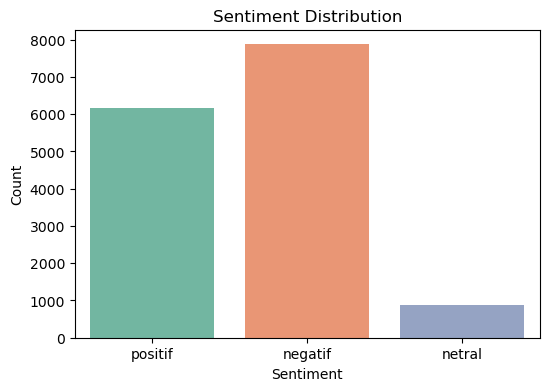

In [ ]:
# memvisualisasikan distribusi kategori sentimen
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='polarity', palette='Set2')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [ ]:
# mengecek distribusi kategori sentimen
df['polarity'].value_counts()

polarity
negatif    7874
positif    6178
netral      886
Name: count, dtype: int64

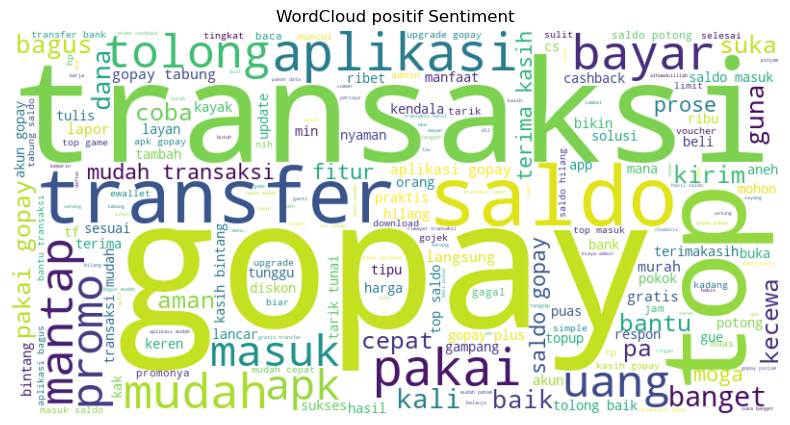

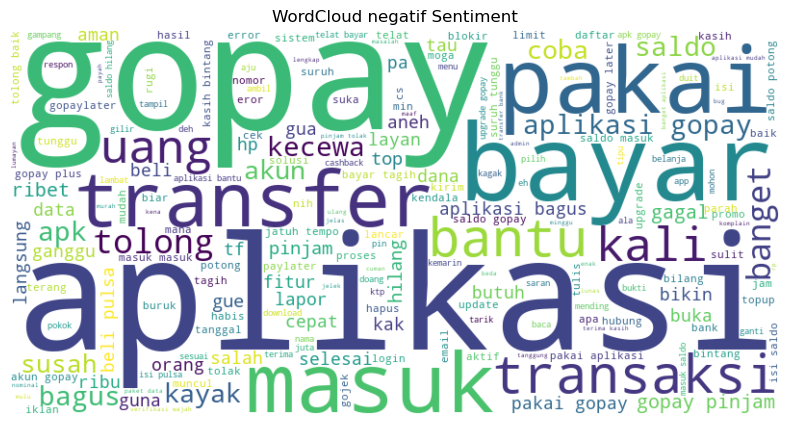

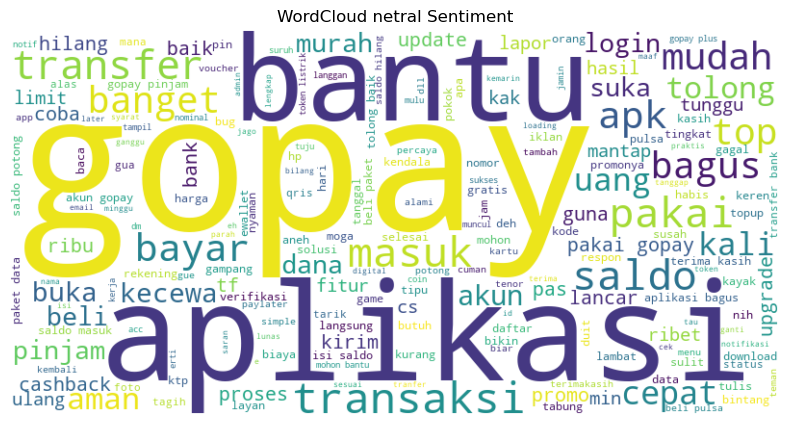

In [ ]:
# memunculkan kata yang sering muncul pada tiap kategori sentimen
kategori = df['polarity'].unique()

for label in kategori:
    text = ' '.join(df[df['polarity'] == label]['final_review'])
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud {label} Sentiment')
    plt.show()

#### Penjelasan

Berdasarkan analisis setiap kategori sentimen, diketahui bahwa mayoritas ulasan pengguna termasuk kategori negatif sebanyak 7.874 data, diikuti oleh sentimen positif dengan 6.178 data, dan sisanya merupakan sentimen netral sebanyak 886 data. Hal ini menunjukkan bahwa sebagian besar pengguna cenderung menyampaikan keluhan atau pengalaman kurang menyenangkan terhadap layanan atau aplikasi. Visualisasi WordCloud pada masing-masing kategori memperkuat temuan ini, di mana kata-kata dominan seperti “gopay”, “transaksi”, “masuk”, dan “aplikasi” muncul di semua sentimen, namun konteks penggunaannya berbeda tergantung polaritasnya. Misalnya, pada sentimen negatif, kata-kata seperti “gagal”, “susah”, dan “ribet” lebih menonjol, sedangkan sentimen positif lebih banyak menampilkan kata seperti “mudah”, “mantap”, dan “promo”. Hal ini memberi gambaran bahwa fitur transaksi, kemudahan akses, dan penggunaan promo menjadi isu utama dalam persepsi pengguna, baik dari sisi apresiasi maupun keluhan.

## **Data Splitting**

In [ ]:
# membagi variabel pada dataset menjadi fitur dan label 
X = df['final_review']
y = df['polarity']

In [ ]:
# membagi dataset menjadi data latih dan data uji dengan persentase 80% untuk data latih dan 20% untuk data uji
X_train, X_test, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# melakukan encoding terhadap label sentimen
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_raw)
y_test_encoded = label_encoder.transform(y_test_raw)

y_train = to_categorical(y_train_encoded)
y_test = to_categorical(y_test_encoded)

In [ ]:
# mengecek mapping dari label hasil encoding
print("Mapping Label:")
for label, encoded_value in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{label}: {encoded_value}")

Mapping Label:
negatif: 0
netral: 1
positif: 2


In [ ]:
# melihat ukuran data latih dan data uji
print('(Data Training) x shape :', X_train.shape)
print('(Data Training) y shape :', y_train.shape)
print('(Data Testing) x shape :', X_test.shape)
print('(Data Testing) y shape :', y_test.shape)

(Data Training) x shape : (11950,)
(Data Training) y shape : (11950, 3)
(Data Testing) x shape : (2988,)
(Data Testing) y shape : (2988, 3)


#### Penjelasan

Sebelum membangun model, data dibagi menjadi fitur (`final_review`) dan label (`polarity`). Dataset kemudian dipisahkan menjadi data latih (80%) dan data uji (20%) dengan stratifikasi agar distribusi label tetap seimbang. Label sentimen yang awalnya berbentuk teks (positif, negatif, netral) diencoding ke bentuk numerik menggunakan LabelEncoder, lalu diubah menjadi one-hot encoding agar sesuai dengan format input yang dibutuhkan oleh model klasifikasi.

## **Modelling**

In [ ]:
# mendefinisikan parameter
vocab_size = 1000
max_length = 30
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [ ]:
# melakukan tokenisasi pada data latih
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

In [ ]:
# melakukan tokenisasi dan padding pada data latih dan data uji
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
# menyimpan model tokenizer
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)

In [ ]:
# mendefinisikan variabel early stopping untuk menghentikan pelatihan model jika tidak ada peningkatan pada data validasi
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#### Penjelasan

Setelah dilakukan Data Splitting, perlu dilakukan tokenisasi dan padding untuk mengubah data teks menjadi format numerik yang dapat diproses oleh model. Tokenisasi digunakan untuk mengkonversi setiap kata dalam review menjadi angka berdasarkan frekuensi atau indeks dalam kamus, sedangkan padding digunakan untuk menyamakan panjang input agar semua data memiliki panjang yang konsisten. Hal ini penting sebelum lanjut ke permodelan algoritma Recurrent Neural Network, Long Short Term Model, dan Gated Recurrent Unit.

### Recurrent Neural Network (RNN)

In [ ]:
# mendefinisikan arsitektur dan kompilasi model RNN
model_RNN = Sequential()
model_RNN.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length))
model_RNN.add(SimpleRNN(64))
model_RNN.add(Dense(3, activation='softmax'))

c:\Users\M Ilham Ramadhan\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# melakukan compile pada model RNN
model_RNN.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
# melakukan pelatihan pada model RNN
history_RNN = model_RNN.fit(
    X_train_pad, y_train, 
    epochs=20, 
    batch_size=128,
    callbacks=[early_stopping],
    validation_data=(X_test_pad, y_test))

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5814 - loss: 0.8511 - val_accuracy: 0.7634 - val_loss: 0.6533
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8235 - loss: 0.5208 - val_accuracy: 0.7992 - val_loss: 0.6109
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8545 - loss: 0.4283 - val_accuracy: 0.8775 - val_loss: 0.3407
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9036 - loss: 0.2793 - val_accuracy: 0.8561 - val_loss: 0.3604
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8911 - loss: 0.3027 - val_accuracy: 0.8618 - val_loss: 0.3792
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9098 - loss: 0.2574 - val_accuracy: 0.8829 - val_loss: 0.3187
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9298 - loss: 0.2047 - val_accuracy: 0.8872 - val_loss: 0.2999
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9337 - loss: 0.1974 - val_accuracy: 0.8842 - v

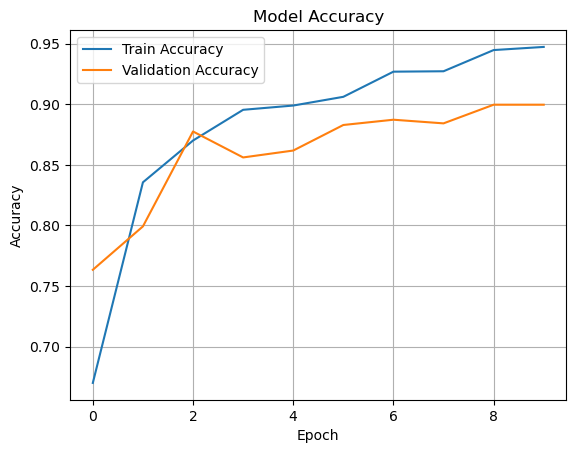

In [ ]:
# memunculkan perubahan akurasi pada tiap epoch pada model RNN
plt.plot(history_RNN.history['accuracy'], label='Train Accuracy')
plt.plot(history_RNN.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)
plt.show()

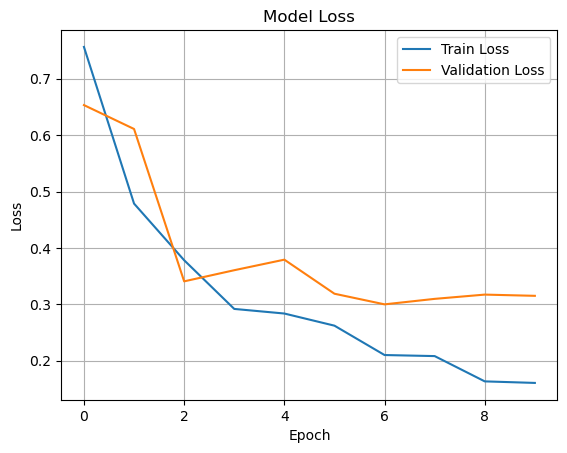

In [ ]:
# memunculkan perubahan loss pada tiap epoch pada model RNN
plt.plot(history_RNN.history['loss'], label='Train Loss')
plt.plot(history_RNN.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# menngevaluasi model RNN
y_pred_prob = model_RNN.predict(X_test_pad)
y_pred_RNN = np.argmax(y_pred_prob, axis=1)
y_test_label = np.argmax(y_test, axis=1)

accuracy_RNN = accuracy_score(y_test_label, y_pred_RNN)
precision_RNN = precision_score(y_test_label, y_pred_RNN, average='weighted')
recall_RNN = recall_score(y_test_label, y_pred_RNN, average='weighted')
f1_RNN = f1_score(y_test_label, y_pred_RNN, average='weighted')


print('RNN Model Evaluation')
print(f'Accuracy    : {accuracy_RNN:.4f}')
print(f'Precision   : {precision_RNN:.4f}')
print(f'Recall      : {recall_RNN:.4f}')
print(f'F1-Score    : {f1_RNN:.4f}')

print('\nAccuracy :')
print('Data Training    : %.4f' % (history_RNN.history['accuracy'][-1]))
print('Data Testing     : %.4f' % (accuracy_RNN))

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
RNN Model Evaluation
Accuracy    : 0.8872
Precision   : 0.8909
Recall      : 0.8872
F1-Score    : 0.8886

Accuracy :
Data Training    : 0.9473
Data Testing     : 0.8872


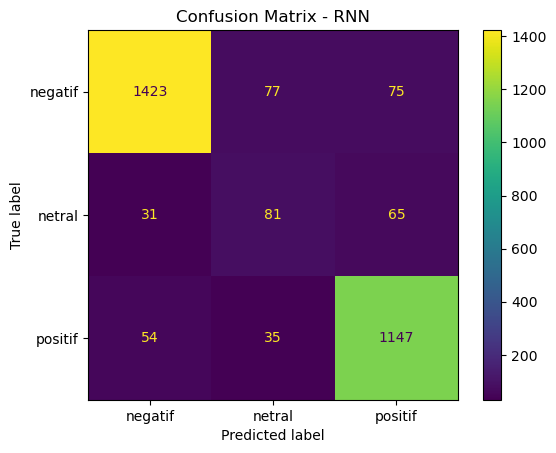

In [ ]:
# memuvisualisasikan confusion matrix pada model RNN
cm_rnn = confusion_matrix(y_test_label, y_pred_RNN, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rnn, display_labels=['negatif', 'netral', 'positif'])

disp.plot()
plt.title("Confusion Matrix - RNN")
plt.show()

#### Penjelasan

Model RNN menunjukkan performa yang cukup baik dalam analisis sentimen dengan akurasi sebesar 88.72% dan F1-score 88.86%. Sedangkan pada grafik akurasi dan loss menunjukkan bahwa model belajar dengan baik seiring bertambahnya epoch, meskipun terdapat sedikit tanda overfitting karena akurasi training (94.73%) lebih tinggi dari testing (88.72%). Dari confusion matrix, model sangat baik mengenali sentimen negatif dan positif, namun masih kesulitan menggolongkan suatu ulasan menjadi netral.

### Long Short-Term Memory (LSTM)

In [184]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length))
model_LSTM.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)))
model_LSTM.add(LSTM(32, dropout=0.3, recurrent_dropout=0.3))
model_LSTM.add(Dense(128, activation='relu'))
model_LSTM.add(Dense(64, activation='relu'))
model_LSTM.add(Dense(3, activation='softmax'))

c:\Users\M Ilham Ramadhan\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [185]:
model_LSTM.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [186]:
history_LSTM = model_LSTM.fit(
    X_train_pad, y_train,
    epochs=20,
    batch_size=128,
    callbacks=[early_stopping],
    validation_data=(X_test_pad, y_test)
)

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 197ms/step - accuracy: 0.5200 - loss: 0.9123 - val_accuracy: 0.7570 - val_loss: 0.7088
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 201ms/step - accuracy: 0.7317 - loss: 0.7295 - val_accuracy: 0.7015 - val_loss: 0.7447
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 214ms/step - accuracy: 0.7241 - loss: 0.7148 - val_accuracy: 0.7353 - val_loss: 0.7149
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 229ms/step - accuracy: 0.7402 - loss: 0.7044 - val_accuracy: 0.7841 - val_loss: 0.5954
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 229ms/step - accuracy: 0.7916 - loss: 0.5860 - val_accuracy: 0.8350 - val_loss: 0.4532
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 229ms/step - accuracy: 0.8420 - loss: 0.4433 - val_accuracy: 0.8732 - val_loss: 0.3501
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 237ms/step - accuracy: 0.8799 - loss: 0.3308 - val_accuracy: 0.8956 - val_loss: 0.3013
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 235ms/step - accuracy: 0.9042 - loss: 0.2618 - val_accu

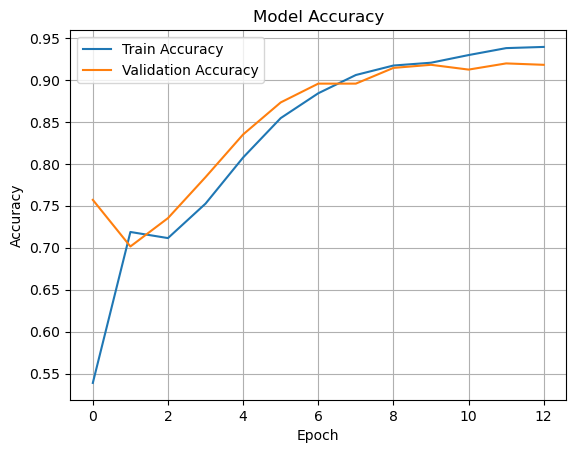

In [191]:
plt.plot(history_LSTM.history['accuracy'], label='Train Accuracy')
plt.plot(history_LSTM.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)
plt.show()

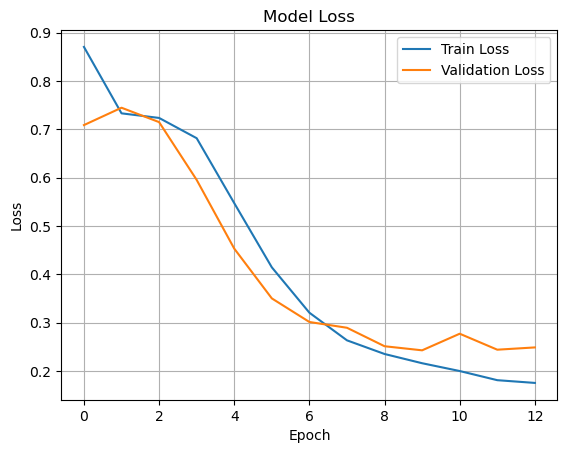

In [192]:
plt.plot(history_LSTM.history['loss'], label='Train Loss')
plt.plot(history_LSTM.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)
plt.show()

In [193]:
y_pred_prob_LSTM = model_LSTM.predict(X_test_pad)
y_pred_LSTM = np.argmax(y_pred_prob_LSTM, axis=1)
y_test_label = np.argmax(y_test, axis=1)

accuracy_LSTM = accuracy_score(y_test_label, y_pred_LSTM)
precision_LSTM = precision_score(y_test_label, y_pred_LSTM, average='weighted')
recall_LSTM = recall_score(y_test_label, y_pred_LSTM, average='weighted')
f1_LSTM = f1_score(y_test_label, y_pred_LSTM, average='weighted')


print('LSTM Model Evaluation')
print(f'Accuracy    : {accuracy_LSTM:.4f}')
print(f'Precision   : {precision_LSTM:.4f}')
print(f'Recall      : {recall_LSTM:.4f}')
print(f'F1-Score    : {f1_LSTM:.4f}')

print('\nAccuracy')
print('Data Training    : %.4f' % (history_LSTM.history['accuracy'][-1]))
print('Data Testing     : %.4f' % (accuracy_LSTM))

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
LSTM Model Evaluation
Accuracy    : 0.9180
Precision   : 0.9131
Recall      : 0.9180
F1-Score    : 0.9133

Accuracy
Data Training    : 0.9393
Data Testing     : 0.9180


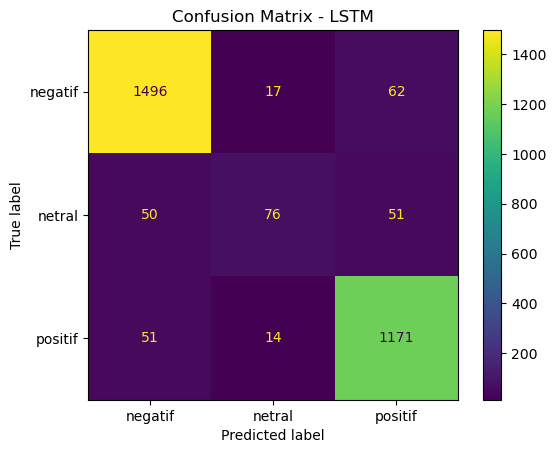

In [194]:
cm_lstm = confusion_matrix(y_test_label, y_pred_LSTM, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lstm, display_labels=['negatif', 'netral', 'positif'])

# Plot
disp.plot()
plt.title("Confusion Matrix - LSTM")
plt.show()

#### Penjelasan

Model LSTM menunjukkan performa yang sangat baik dalam klasifikasi sentimen. Grafik akurasi menunjukkan peningkatan stabil selama pelatihan, dengan akurasi data training mencapai 93.93% dan data testing 91.80%. Grafik loss juga menunjukkan penurunan yang konsisten, menandakan proses pelatihan yang efektif. Nilai precision (91.31%), recall (91.80%), dan F1-score (91.33%) menunjukkan keseimbangan yang baik antara prediksi benar dan kesalahan. Confusion matrix memperlihatkan bahwa model mampu mengklasifikasikan kelas negatif dan positif dengan sangat akurat, meskipun prediksi untuk kelas netral masih kurang optimal. Secara keseluruhan, model ini cukup andal untuk tugas klasifikasi sentimen.

### Gated Recurrent Unit (GRU)

In [195]:
model_GRU = Sequential()
model_GRU.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length))
model_GRU.add(Bidirectional(GRU(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)))
model_GRU.add(GRU(64, dropout=0.3, recurrent_dropout=0.3))
model_GRU.add(Dense(128, activation='relu'))
model_GRU.add(Dense(64, activation='relu'))
model_GRU.add(Dense(3, activation='softmax'))

c:\Users\M Ilham Ramadhan\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [196]:
model_GRU.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [197]:
history_GRU = model_GRU.fit(
    X_train_pad, y_train, 
    epochs=20, 
    batch_size=128, 
    callbacks=[early_stopping], 
    validation_data=(X_test_pad, y_test))

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 34s 289ms/step - accuracy: 0.5168 - loss: 0.9179 - val_accuracy: 0.5271 - val_loss: 0.8646
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 28s 303ms/step - accuracy: 0.5443 - loss: 0.8519 - val_accuracy: 0.7748 - val_loss: 0.6132
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 30s 319ms/step - accuracy: 0.8289 - loss: 0.4814 - val_accuracy: 0.8809 - val_loss: 0.3206
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 31s 327ms/step - accuracy: 0.8964 - loss: 0.2851 - val_accuracy: 0.9093 - val_loss: 0.2567
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 31s 331ms/step - accuracy: 0.9197 - loss: 0.2246 - val_accuracy: 0.9093 - val_loss: 0.2546
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 32s 337ms/step - accuracy: 0.9273 - loss: 0.2076 - val_accuracy: 0.9173 - val_loss: 0.2373
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 32s 340ms/step - accuracy: 0.9371 - loss: 0.1843 - val_accuracy: 0.9197 - val_loss: 0.2328
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 42s 450ms/step - accuracy: 0.9400 - loss: 0.1741 - val_accu

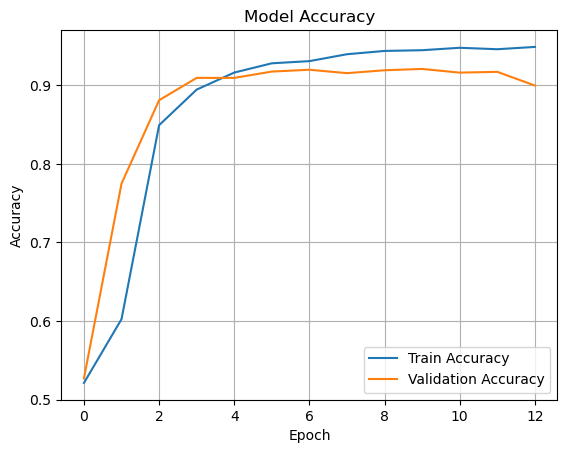

In [202]:
plt.plot(history_GRU.history['accuracy'], label='Train Accuracy')
plt.plot(history_GRU.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)
plt.show()

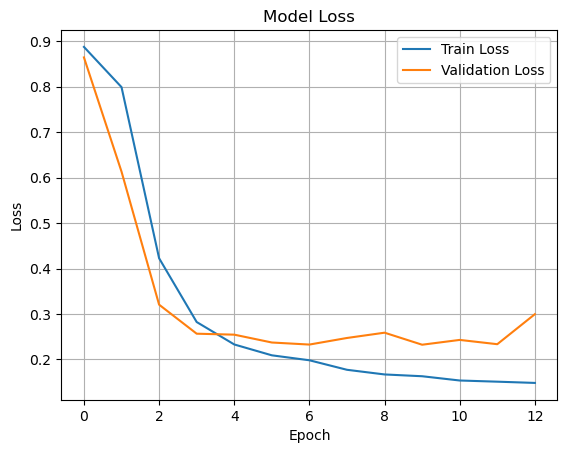

In [203]:
plt.plot(history_GRU.history['loss'], label='Train Loss')
plt.plot(history_GRU.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)
plt.show()

In [204]:
y_pred_prob_GRU = model_GRU.predict(X_test_pad)
y_pred_GRU = np.argmax(y_pred_prob_GRU, axis=1)
y_test_label = np.argmax(y_test, axis=1)

accuracy_GRU = accuracy_score(y_test_label, y_pred_GRU)
precision_GRU = precision_score(y_test_label, y_pred_GRU, average='weighted')
recall_GRU = recall_score(y_test_label, y_pred_GRU, average='weighted')
f1_GRU = f1_score(y_test_label, y_pred_GRU, average='weighted')


print('GRU Model Evaluation')
print(f'Accuracy    : {accuracy_GRU:.4f}')
print(f'Precision   : {precision_GRU:.4f}')
print(f'Recall      : {recall_GRU:.4f}')
print(f'F1-Score    : {f1_GRU:.4f}')

print('\nAccuracy')
print('Data Training    : %.4f' % (history_GRU.history['accuracy'][-1]))
print('Data Testing     : %.4f' % (accuracy_GRU))

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step
GRU Model Evaluation
Accuracy    : 0.9207
Precision   : 0.9167
Recall      : 0.9207
F1-Score    : 0.9157

Accuracy
Data Training    : 0.9487
Data Testing     : 0.9207


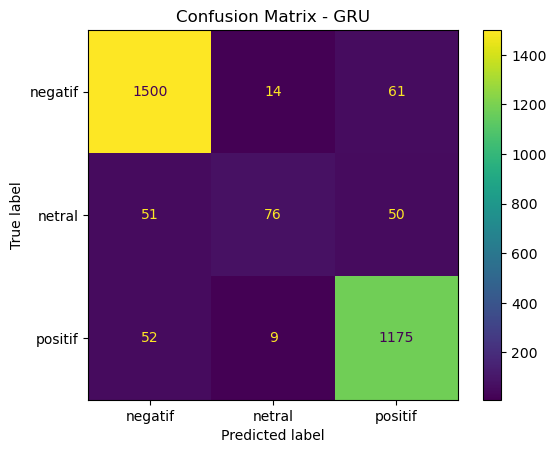

In [205]:
cm_gru = confusion_matrix(y_test_label, y_pred_GRU, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_gru, display_labels=['negatif', 'netral', 'positif'])

# Plot
disp.plot()
plt.title("Confusion Matrix - GRU")
plt.show()

#### Penjelasan

Model GRU menunjukkan performa yang sangat baik dalam tugas klasifikasi sentimen. Akurasi data training sebesar 94.87% dan data testing 92.07% menunjukkan bahwa model belajar dengan baik tanpa overfitting yang signifikan. Grafik akurasi menunjukkan peningkatan stabil, sementara grafik loss menurun secara konsisten, menandakan pelatihan berjalan efektif. Nilai precision (91.67%), recall (92.07%), dan F1-score (91.57%) menandakan model seimbang dalam mengenali dan memprediksi berbagai kelas. Berdasarkan confusion matrix, model GRU mampu memprediksi sentimen positif dan negatif dengan sangat baik, sementara kelas netral masih menjadi tantangan. Secara keseluruhan, model GRU sangat andal dan akurat dalam mengklasifikasikan sentimen.

## **Model Summary**

In [ ]:
# menampilkan perbandingan hasil evaluasi model
evaluation = {
    'Model': ['Recurrent Neural Network', 'Long Short Term Model', 'Gated Recurrent Unit'],
    'Accuracy': [accuracy_RNN, accuracy_LSTM, accuracy_GRU],
    'Precision': [precision_RNN, precision_LSTM, precision_GRU],
    'Recall': [recall_RNN, recall_LSTM, recall_GRU],
    'F1-Score': [f1_RNN, f1_LSTM, f1_GRU]
}

summary = pd.DataFrame(evaluation)

# Format ke persen
summary[['Accuracy', 'Precision', 'Recall', 'F1-Score']] = summary[['Accuracy', 'Precision', 'Recall', 'F1-Score']].applymap(lambda x: f"{x*100:.2f}%")

print(summary)

                      Model Accuracy Precision  Recall F1-Score
0  Recurrent Neural Network   88.72%    89.09%  88.72%   88.86%
1     Long Short Term Model   91.80%    91.31%  91.80%   91.33%
2      Gated Recurrent Unit   92.07%    91.67%  92.07%   91.57%


C:\Users\M Ilham Ramadhan\AppData\Local\Temp\ipykernel_368\2476025607.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary[['Accuracy', 'Precision', 'Recall', 'F1-Score']] = summary[['Accuracy', 'Precision', 'Recall', 'F1-Score']].applymap(lambda x: f"{x*100:.2f}%")


#### Penjelasan

Dalam analisis sentimen terhadap ulasan pengguna aplikasi Gopay, model Recurrent Neural Network (RNN), Long Short-Term Memory (LSTM), dan Gated Recurrent Unit (GRU) menunjukkan performa yang cukup baik dengan perbedaan tingkat akurasi dan efisiensi. RNN sebagai model dasar menghasilkan akurasi sebesar 88.72%, dengan precision dan recall yang seimbang, namun model ini memiliki keterbatasan dalam menangkap hubungan konteks jangka panjang dalam teks, sehingga performanya lebih rendah dibanding model lainnya. Sementara itu, LSTM berhasil meningkatkan akurasi menjadi 91.80% dengan keunggulannya untuk mengingat informasi penting dari teks yang panjang dan kompleks yang relevan dengan analisis sentimen. Sedangkan GRU yang memiliki struktur lebih sederhana daripada LSTM namun tetap efektif dalam menangani konteks jangka panjang, mencatatkan performa terbaik dengan akurasi 92.07% dan F1-score tertinggi sebesar 91.57%. Performa unggul GRU menjadikannya pilihan paling efisien dan handal dalam melakukan klasifikasi sentimen pada data ulasan pengguna, karena mampu mencapai keseimbangan antara kompleksitas model dan ketepatan hasil.

In [ ]:
# menyipan model
model_GRU.save('model_gru.h5')
model_LSTM.save('model_lstm.h5')
model_RNN.save('model_rnn.h5')